In [1]:
import os
from pydantic import BaseModel, Field
import operator
import pandas as pd
import duckdb
from typing import TypedDict, Literal, Annotated, Callable, Optional, Sequence, Type, TypeVar, Union, cast, List, Any
from IPython.display import Image, display

# LangChain / LangGraph
from langchain_ollama import ChatOllama
from langchain_core.prompts import PromptTemplate
from langchain_core.messages import HumanMessage, AIMessage, BaseMessage, SystemMessage, ToolMessage
from langgraph.graph import StateGraph, START, END
from langgraph.types import Command
from langgraph.graph import MessagesState
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import InMemorySaver
from backend.prompts import *

In [2]:
# ============================================================
# LLMs (keep your configured models)
# ============================================================
supervisor_llm = ChatOllama(model="deepseek-r1:8b", temperature=0.0)
agent_llm = ChatOllama(model="deepseek-r1:8b", temperature=0.0)
summary_llm = ChatOllama(model="deepseek-r1:8b", temperature=0.0)
conv_llm = ChatOllama(model="deepseek-r1:8b", temperature=0.7)

In [3]:
# ============================================================
# CSV path (your file)
# ============================================================
CSV_PATH = "data/in/Sales Dataset/Sale Report.csv"

In [4]:
# ============================================================
# STATE
# ============================================================
class GraphState(TypedDict, total=False):
    # inputs
    user_query: str

    # data
    file_path: str

    # intermediate results
    context_data: Any
    resolved_query: str
    extracted_answer: str
    summarized_answer: str

    # book keeping
    messages: Annotated[Sequence[BaseMessage], add_messages]
    resolve_history: Annotated[list[str], operator.add]
    extract_history: Annotated[list[str], operator.add]
    summarized_history: Annotated[list[str], operator.add]
    worker_history: Annotated[list[str], operator.add]

In [5]:
# ============================================================
# SUPERVISOR NODE
# ============================================================
system_prompt = (
    "You are an supervisor controlling 5 workers:\n"
    "- data_processing\n"
    "- resolve_query\n"
    "- extract_data\n"
    "- summarization\n"
    "- conversation\n\n"

    "Your job is to pick the correct NEXT worker.\n\n"

    "VERY IMPORTANT RULES:\n"
    "1. Only choose 'conversation' if the user is doing small talk, greetings,\n"
    "   joking, personal chat, or unrelated to analytics.\n"
    "2. If user ask the question about the data and context_data is EMPTY or None → ALWAYS choose data_processing.\n"
    "3. If the user question asks anything about data, CSV, file, stock, category,\n"
    "   columns, rows, values, metrics, aggregation, filtering, analytics →\n"
    "   DO NOT choose 'conversation'. Choose resolve_query.\n"
    "4. If resolved_query exists AND extracted_answer is empty → choose extract_data.\n"
    "5. If extracted_answer exists AND summarized_answer is empty → choose summarization.\n"
    "6. If summarized_answer exists → FINISH.\n\n"

    "Respond ONLY in JSON:\n"
    "{\"next\": \"data_processing\" | \"resolve_query\" | \"extract_data\" | \"summarization\" | \"conversation\" | \"FINISH\"}"
)

class Router(TypedDict):
    """Output schema for supervisor routing decision"""
    next: Literal["data_processing", "resolve_query", "extract_data", "summarization", "conversation", "FINISH"]

def supervisor_node(state: GraphState) -> Command[
    Literal["data_processing","resolve_query", "extract_data", "summarization", "conversation", "__end__"]
    ]:
    """Supervisor node that routes to next worker based on state"""

    messages = [
        SystemMessage(content=system_prompt),
        # HumanMessage(content=f"user_query: {state.get('user_query')}"),
        HumanMessage(content=f"file_path: {state.get('file_path')}"),
        HumanMessage(content=f"context_data: {state.get('context_data')}"),
        HumanMessage(content=f"resolved_query: {state.get('resolved_query')}"),
        HumanMessage(content=f"extracted_data: {state.get('extracted_data')}"),
        # HumanMessage(content=f"summarized_answer: {state.get('summarized_answer')}"),
        # HumanMessage(content=f"worker_history: {state.get('worker_history')}")
        *state.get("messages", []),
    ]

    # Invoke supervisor LLM to decide next worker
    decision = supervisor_llm.with_structured_output(Router).invoke(messages)
    goto = decision["next"]

    print(f"[Supervisor] Next Worker → {goto}")

    if goto == "FINISH":
        goto = END

    return Command(
        # update={"messages": [HumanMessage(content=state['user_query'])]},
        goto=goto
        )

def data_processing(state: GraphState):
    """Data Preprocessing Worker (if needed)"""
    
    # Initialize context data
    file_path = state.get("file_path", "")

    # Check file existence or accessible
    if not os.path.exists(file_path):
        context_data = None
        msg = f"[data_processing] File path {file_path} does not exist."

    # Load csv
    elif file_path.lower().endswith(".csv"):
        try:
            context_data = pd.read_csv(file_path)
            msg = "[data_processing] CSV loaded successfully"
        except Exception as e:
            context_data = None
            msg = f"[data_processing] Error loading CSV: {str(e)}"
            
    # Load json
    elif file_path.lower().endswith(".json"):
        try:
            context_data = pd.read_json(file_path)
            msg = "[data_processing] JSON loaded successfully."
        except Exception as e:
            context_data = None
            msg= f"Error loading JSON: {str(e)}"
            
    # Load excel
    elif file_path.lower().endswith(".xlsx"):
        try:
            context_data = pd.read_excel(file_path)
            msg = "[data_processing] Excel loaded successfully."
        except Exception as e:
            context_data =  None
            msg = f"[data_processing] Error loading Excel: {str(e)}"

    # Load text
    elif file_path.lower().endswith(".txt"):
        try:
            with open(file_path, 'r') as f:
                text_data = f.read()
            context_data = text_data
            msg = "[data_processing] Text file loaded successfully."
        except Exception as e:
            context_data = None
            msg = f"Error loading text file: {str(e)}"

    # Unsupported format
    else:
        context_data = None
        msg = f"Unsupported file format for path: {file_path}"
    
    # Print status
    print(msg)

    return Command(
        update={
            "context_data": context_data,
            "messages": [AIMessage(content=msg)],
            "worker_history": ["data_processing"]
        },
        goto="supervisor"
    )

def resolve_query(state: GraphState):
    """Converts natural language → SQL query"""

    # Get context data
    context_data = state.get("context_data")

    # Inform the LLM about the actual CSV columns so it produces correct SQL

    if context_data is None:
        sql = "No context data available"
        print("[resolve_query] No context data.")

    else:
        columns = list(context_data.columns)
        user_q = state.get("user_query", "")
        
        # Create prompt
        # prompt = PromptTemplate(
        #     template=resolve_query_template,
        #     input_variables=["context_data"],
        #     validate_template=True
        #     )

        prompt = [
            SystemMessage(content="Convert the user question to a DuckDB SQL SELECT query."),
            HumanMessage(content=f"Columns: {columns}\nQuestion: {user_q}")
        ]

        # Create chain
        # chain = prompt | agent_llm

        # Invoke chain/LLM
        # sql = chain.invoke({"context_data": context_data}).content
        sql = agent_llm.invoke(prompt).content

        print("[resolve_query] SQL generated:\n", sql)

    return Command(
        update={
            "resolved_query": sql,
            "resolve_history": [sql],
            "messages": [AIMessage(content=f"Generated SQL: {sql}")],
            "worker_history": ["resolve_query"]
        },
        goto="supervisor"
    )

def extract_data(state: GraphState):
    """Executes SQL on DuckDB against the provided CSV"""

    # Get the SQL query from state
    sql_query = state.get("resolved_query", "").strip()

    # Get context data
    df = state.get("context_data", None)

    if df is None:
        result_text = "No context data available to execute SQL query."
        print("[extract_data] No context data.")

    elif not sql_query:
        result_text = "No SQL query available to execute. The resolver may have failed to produce SQL."
        print("[extract_data] No SQL to execute.")

    else:
        # Execute SQL safely and return text representation of result
        try:
            # Create DuckDB in-memory connection
            duckdb_conn = duckdb.connect()
            duckdb_conn.register("retail_sales", df) # Register DataFrame as table
            result_df = duckdb_conn.execute(sql_query).df()

            # Pretty string (limit rows to keep responses compact)
            if result_df.shape[0] > 50:
                result_text = result_df.head(100).to_string(index=False) + f"\n\n... ({result_df.shape[0]} rows total)"
            else:
                result_text = result_df.to_string(index=False)

        except Exception as e:
            result_text = f"SQL Execution Error: {str(e)}"
            print("[extract_data] SQL error:", e)

    return Command(
        update={
            "extracted_data": result_text,
            "extract_history": [result_text],
            "messages": [AIMessage(content=f"SQL Result:\n{result_text}")],
            "worker_history": ["extract_data"]
            },
        goto="supervisor"
        )

def summarization(state: GraphState):
    """Produces polished business insight (LLM)"""

    # Get relevant state info
    user_q = state.get("user_query", "")
    sql = state.get("resolved_query", "")
    data = state.get("extracted_data", "")

    # Create prompt
    prompt = [
        SystemMessage(content="Summarize extracted data into a 1-3 sentence business insight."),
        HumanMessage(content=f"Question: {user_q}\nSQL: {sql}\nData:\n{data}")
        ]

    # Invoke the LLM
    answer = summary_llm.invoke(prompt).content
    
    # print("[summarization] Insight generated.")

    return Command(
        update={
            "summarized_answer": answer,
            "summarized_history": [answer],
            "messages": [AIMessage(content=answer)],
            "worker_history": ["summarization"]
        },
        goto=END # or "__end__"
    )

def conversation(state: GraphState):
    """Used of having conversation after data insights"""

    # print(f"[Conversation agent]: {state.get('messages')}")

    # get query and history
    user_query = state.get("user_query", "")
    msg_history = state.get("messages", [])

    messages = [
        SystemMessage(content="Friendly assistant. Never generate SQL. Continue conversation naturally."),
        *msg_history,   # expand message list
        HumanMessage(content=user_query)
        ]

    # invoke LLM
    reply = conv_llm.invoke(messages).content

    return Command(
        update={
            "summarized_answer": reply,
            # "summarized_history": [reply],
            "worker_history": ["conversation"],
            "messages": [AIMessage(content=reply)]
        },
        goto=END
    )


In [6]:
# ============================================================
# BUILD GRAPH
# ============================================================
graph = StateGraph(GraphState)

# Add nodes
graph.add_node("supervisor", supervisor_node)
graph.add_node("data_processing", data_processing)
graph.add_node("resolve_query", resolve_query)
graph.add_node("extract_data", extract_data)
graph.add_node("summarization", summarization)
graph.add_node("conversation", conversation)

# Add edges
graph.add_edge(START, "supervisor")
graph.add_edge("resolve_query", "supervisor")
graph.add_edge("data_processing", "supervisor")
graph.add_edge("extract_data", "supervisor")

# Initialize in-memory checkpointing
checkpointer = InMemorySaver()

# Compile graph
chatbot = graph.compile(checkpointer=checkpointer)

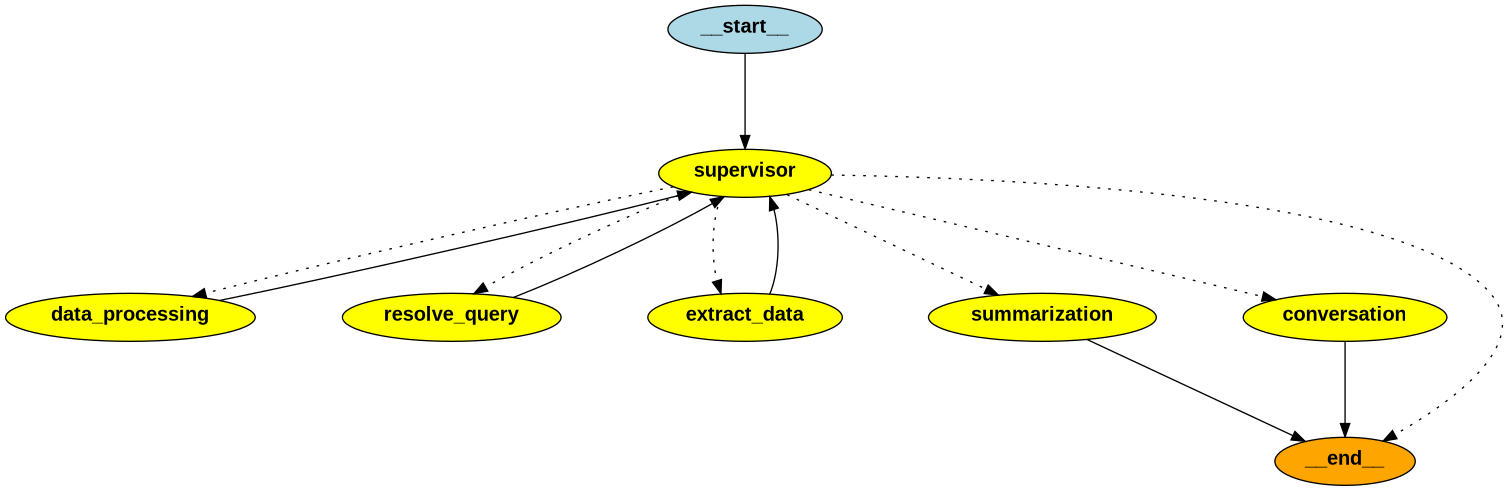

In [7]:
g = chatbot.get_graph()
display(Image(g.draw_png()))

In [8]:
# ============================================================
# CONVERSATION LOOP
# ============================================================
def run_conversation(initial_state: dict, config: dict):
    """conversation loop to ask questions interactively"""

    print("Type 'exit/quit/bye' to quit.\n")

    while True:
        query = input("User👨‍💼: ").strip()
        if query.lower() in ("exit", "quit", "bye"):
            break
            
        # update state
        initial_state["user_query"] = query

        # invoke chatbot   
        result = chatbot.invoke(
            {**initial_state, "messages": [HumanMessage(content=query)]},
            config=config
            )

        # Prefer final summarized_answer, else extracted, else resolved_query
        out = (
            result.get("summarized_answer") or
            result.get("extracted_answer") or
            result.get("resolved_query") or
            "No answer"
            )
        
        print('AI🤖:', out)
        print("-----------------\n")

In [10]:
# Initialize the variables
CSV_PATH = "data/in/Sales Dataset/Sale Report.csv"
initial_state = {
    "file_path": CSV_PATH,
    "messages": [],
    "resolve_history": [],
    "extract_history": [],
    "summarized_history": [],
    "worker_history": [],
    }

config = {"configurable": {"thread_id": "1"}}

# Run the loop
run_conversation(initial_state, config)

Type 'exit/quit/bye' to quit.

[Supervisor] Next Worker → conversation
AI🤖: Hi! How can I help you today?
-----------------

[Supervisor] Next Worker → conversation
AI🤖: Nice to meet you, Gaurav! How can I assist you?
-----------------

